In [1]:
import pandas as pd
import numpy as np
import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import backend as K
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, '/Users/yuesongyang/Desktop/BT4222_repo')
from backtest import *

In [2]:
features = pd.read_csv("../../cooked_complete_dataset.csv")

In [3]:
features.dropna(inplace = True)

In [4]:
features['date'] = features['date'].apply(lambda x: datetime.datetime.strptime(x, "%d/%m/%y"))
features["date"] = pd.to_datetime(features["date"], format='%d/%m/%Y', infer_datetime_format=True)

In [5]:
features.head()

,date,Adj_Close_BTC-USD,Open_BTC-USD,High_BTC-USD,Low_BTC-USD,Volume_BTC-USD,Adj_Close_SPY,Adj_Close_GLD,Adj_Close_CHFUSD=X,Adj_Close_CNYUSD=X,Adj_Close_EURUSD=X,Adj_Close_GBPUSD=X,Adj_Close_JPYUSD=X,coindesk_sentiment,num_of_coindesk_posts,reddit_comments_sentiments,top_50_reddit_posts_sentiments,blockchain_transactions_per_block,blockchain_hash_rates
0,2020-12-14,19246.64453,19144.49219,19305.09961,19012.70898,2.247400e+10,361.926788,171.539993,1.125442,0.152772,1.213340,1.331824,0.009621,0.249489,12,0.188275,0.297238,2167.931034,134533587.6
1,2020-12-15,19417.07617,19246.91992,19525.00781,19079.84180,2.674198e+10,366.819824,173.940002,1.127930,0.152679,1.214890,1.333084,0.009614,0.173773,18,0.144389,0.399427,2288.857143,133351912.2
2,2020-12-16,21310.59766,19418.81836,21458.90820,19298.31641,4.440901e+10,367.395508,174.899994,1.129382,0.152945,1.215430,1.344447,0.009649,0.341491,11,0.137256,0.489673,2204.314685,132323572.3
3,2020-12-17,22805.16211,21308.35156,23642.66016,21234.67578,7.137861e+10,369.449982,176.740005,1.129446,0.153109,1.219959,1.350293,0.009664,0.197572,10,0.156723,0.636030,2399.077519,132373208.7
4,2020-12-18,23137.96094,22806.79688,23238.60156,22399.81250,4.038790e+10,367.974792,176.440002,1.130301,0.153090,1.226272,1.357018,0.009696,0.315601,2,0.166419,0.107093,2392.031847,131791042.0


**Log transform the features. Features are time series by nature and log transformation makes it stationary.**

In [6]:
# def log_return_transformation(df, columns='all'):
#     if columns == 'all':
#         for column in list(df.columns):
#             if column != 'date':
#                 # log rate of change
#                 df[column] = np.log(df[column]/df[column].shift(1))
#     else:
#         for column in columns:
#                 df[column] = np.log(df[column]/df[column].shift(1))

#     df = df.dropna()
#     return df

# features = log_return_transformation(features, 
#                                      columns = features.drop(
#                                          ['date', 'Adj_Close_BTC-USD', 'coindesk_sentiment',
#                                          'num_of_coindesk_posts', ''], axis = 1).columns.tolist())

**Helper functions to create lags for features and calculate RMSE**

In [7]:
def lag(data, dic):
    cols = []
    for key, value in dic.items():
        for i in range(1, value+1):
            cols.append(data[key].shift(i).rename('{}_lag{}'.format(data[key].name, i)))
    return pd.concat([data["date"],data["Adj_Close_BTC-USD"]] + cols, axis = 1)

In [8]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

## Without Sentiments

#### 1. Create feature lags

In [9]:
feature_lags = {"Adj_Close_BTC-USD" : 2, 
                "Volume_BTC-USD" : 1, 
                "Adj_Close_SPY" : 1,
                "Adj_Close_GLD" : 1,
                "Adj_Close_CHFUSD=X" : 1,
                "Adj_Close_CNYUSD=X" : 1,
                "Adj_Close_EURUSD=X" : 1,
                "Adj_Close_GBPUSD=X" : 1,
                "Adj_Close_JPYUSD=X" : 1,
                "blockchain_transactions_per_block" : 1,
                "blockchain_hash_rates" : 1}

data = lag(features, feature_lags)

#### 2. Handle train-test split

In [10]:
# data['date'] = data['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
# data["date"] = pd.to_datetime(data["date"], format='%d/%m/%Y', infer_datetime_format=True)
data = data[data["date"] >= "1/1/2021"]

train = data[data["date"] <= "2021-03-10"]
test = data[(data["date"] > "2021-03-10") & (data["date"] <= "2021-04-5")]

x_train = train.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_train = train["Adj_Close_BTC-USD"]

x_test = test.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_test = test["Adj_Close_BTC-USD"]

#### 3. MinMax scale the features

In [11]:
sc = MinMaxScaler(feature_range = (0, 1))
sc.fit(x_train)
x_train_trans = sc.transform(x_train)
x_test_trans = sc.transform(x_test)

#### 4. Transform the feature shapes to fit into LSTM

In [12]:
x_train_trans = x_train_trans.reshape(x_train_trans.shape[0], x_train_trans.shape[1], 1)
x_test_trans = x_test_trans.reshape(x_test_trans.shape[0], x_test_trans.shape[1], 1)

#### 5. Define a Grid Search function

In [13]:
def LSTM_GS(layer_spe, time_step):
    regressor = Sequential()
    count = 0
    for unit in layer_spe:
        count += 1 
        if len(layer_spe) == 1:
            regressor.add(LSTM(unit, activation = "relu", input_shape = (time_step, 1))) # batch size, time steps, data dimension
            regressor.add(Dropout(0.3))
        else:
            if count == 1:
                regressor.add(LSTM(unit, activation = "relu", return_sequences=True, input_shape = (time_step, 1))) # batch size, time steps, data dimension
                regressor.add(Dropout(0.3))
            elif count < len(layer_spe): 
                regressor.add(LSTM(unit, activation = "relu", return_sequences=True))
                regressor.add(Dropout(0.3))
            else:
                regressor.add(LSTM(unit, activation = "relu"))
                regressor.add(Dropout(0.3))
            
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'Adam', loss = root_mean_squared_error)
    regressor.fit(x_train_trans, y_train, epochs = 200, verbose = 0)
    
    yhat = regressor.predict(x_test_trans)
    return mean_squared_error(y_train, regressor.predict(x_train_trans), squared = False), mean_squared_error(y_test, yhat, squared = False)

#### 6. Grid Search on a few hyperparameters combinations

In [14]:
res = []
# 1 layer
for unit in (4,8,16,32):
    for time_step in (1,2,3,4,5):
        res.append((([unit],time_step),LSTM_GS([unit], time_step)))

# 2 layers
for unit in (8,16,32):
    for time_step in (1,2,3,4,5):
        res.append((([unit, unit//2],time_step),LSTM_GS([unit, unit//2], time_step)))

# 3 layers
for unit in (8,16,32):
    for time_step in (1,2,3,4,5):
        res.append((([unit, unit//2, unit//4],time_step),LSTM_GS([unit, unit//2, unit//4], time_step)))

In [15]:
# best combi
sorted(res, key = lambda x : x[1])[0]

(([16], 4), (2627.962160944945, 2967.8839958428725))

In [16]:
layer_config = sorted(res, key = lambda x : x[1])[0][0][0]
time_config = sorted(res, key = lambda x : x[1])[0][0][1]

#### 7. Define a function to retrain the model with selected hyperparameters and all data avilable

In [17]:
x_refit = data.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_refit = data["Adj_Close_BTC-USD"]
x_refit_trans = sc.transform(x_refit)
x_refit_trans = x_refit_trans.reshape(x_refit_trans.shape[0], x_refit_trans.shape[1], 1)

In [18]:
def LSTM_pipe(layer_spe, time_step):
    regressor = Sequential()
    count = 0
    for unit in layer_spe:
        count += 1 
        if len(layer_spe) == 1:
            regressor.add(LSTM(unit, activation = "relu", input_shape = (time_step, 1))) # batch size, time steps, data dimension
            regressor.add(Dropout(0.3))
        else:
            if count == 1:
                regressor.add(LSTM(unit, activation = "relu", return_sequences=True, input_shape = (time_step, 1))) # batch size, time steps, data dimension
                regressor.add(Dropout(0.3))
            elif count < len(layer_spe): 
                regressor.add(LSTM(unit, activation = "relu", return_sequences=True))
                regressor.add(Dropout(0.3))
            else:
                regressor.add(LSTM(unit, activation = "relu"))
                regressor.add(Dropout(0.3))
            
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'Adam', loss = root_mean_squared_error)
    regressor.fit(x_refit_trans, y_refit, epochs = 200, verbose = 0)
    return regressor

In [19]:
model = LSTM_pipe(layer_config, time_config)

#### 8. Backtesting

In [20]:
# predicted value
yhat = model.predict(x_refit_trans, verbose=0)

In [30]:
for b in [x[0] for x in yhat]:
    print(b)

29175.033
29213.16
30785.422
32037.998
31474.178
32102.24
34178.68
37014.03
38641.195
38357.688
37707.492
36413.07
33961.94
34818.668
36411.46
35696.246
34468.523
34002.715
34155.28
34754.543
35283.17
33477.89
32710.648
32475.19
32283.643
32766.945
32784.92
30917.729
31428.875
32587.621
32397.031
31704.465
32506.479
34010.457
35421.945
36396.61
36746.047
37879.656
37981.047
42273.15
44858.594
44109.95
44909.812
45934.02
45445.664
46127.508
46470.04
46723.93
48796.83
48856.277
51160.414
53107.32
53642.965
52963.043
49041.7
46965.61
44555.906
49250.066
42313.492
41906.656
44866.86
45444.703
45532.234
44673.83
44886.234
44702.57
46084.367
47373.387
49979.65
52160.71
54123.516
54642.723
57026.68
56980.67
54961.305
53861.297
55619.934
55125.848
54750.9
54967.305
54526.727
52933.164
51450.723
50530.562
49343.742
51252.85
52898.055
53237.48
54435.48
55618.207
56594.35
57114.92
57288.83
56379.72
56101.977


In [22]:
# weighted sentiments
sentiments = features[features["date"].isin(data.date)]
sentiments = sentiments["reddit_comments_sentiments"] + sentiments["top_50_reddit_posts_sentiments"]
sentiments = ["positive" if x > np.mean(sentiments) else "negative" for x in sentiments]

In [23]:
returns_without_adj = backtest_regression_noSentiment([x[0] for x in yhat], 
                                                      data.date.tolist(), 
                                                      "LSTM_regression_no_sentiment")

In [24]:
returns_with_adj = backtest_regression_WithSentiment([x[0] for x in yhat], 
                                  data.date.tolist(), 
                                  sentiments, "LSTM_regression_with_sentiment")

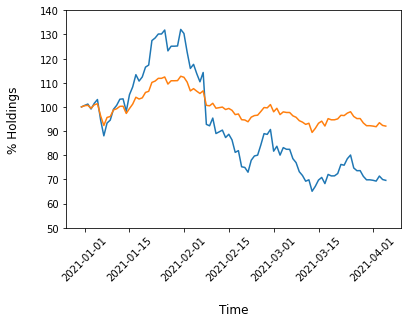

In [38]:
plt.plot([data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist(), [100*x for x in returns_without_adj])
plt.plot([data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist(), [100*x for x in returns_with_adj])
plt.xticks(rotation = 45)
plt.ylim(bottom = 50, top = 140)
plt.ylabel("% Holdings", labelpad = 20, fontsize = 12)
plt.xlabel("Time", labelpad = 20, fontsize = 12)
plt.show()

## With Sentiments

In [26]:
feature_lags = {"Adj_Close_BTC-USD" : 2, 
                "Volume_BTC-USD" : 1, 
                "Adj_Close_SPY" : 1,
                "Adj_Close_GLD" : 1,
                "Adj_Close_CHFUSD=X" : 1,
                "Adj_Close_CNYUSD=X" : 1,
                "Adj_Close_EURUSD=X" : 1,
                "Adj_Close_GBPUSD=X" : 1,
                "Adj_Close_JPYUSD=X" : 1,
                "blockchain_transactions_per_block" : 1,
                "blockchain_hash_rates" : 1,
                "coindesk_sentiment" : 1,
                "num_of_coindesk_posts" : 1,
                "reddit_comments_sentiments" : 1,
                "top_50_reddit_posts_sentiments" : 1}

data = lag(features, feature_lags)
# data['date'] = data['date'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
# data["date"] = pd.to_datetime(data["date"], format='%d/%m/%Y', infer_datetime_format=True)

data = data[data["date"] >= "1/1/2021"]

train = data[data["date"] <= "2021-03-10"]
test = data[(data["date"] > "2021-03-10") & (data["date"] <= "2021-04-5")]

x_train = train.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_train = train["Adj_Close_BTC-USD"]

x_test = test.drop(["date", "Adj_Close_BTC-USD"], axis = 1)
y_test = test["Adj_Close_BTC-USD"]

sc = MinMaxScaler(feature_range = (0, 1))
sc.fit(x_train)
x_train_trans = sc.transform(x_train)
x_test_trans = sc.transform(x_test)

x_train_trans = x_train_trans.reshape(x_train_trans.shape[0], x_train_trans.shape[1], 1)
x_test_trans = x_test_trans.reshape(x_test_trans.shape[0], x_test_trans.shape[1], 1)

In [27]:
res2 = []
# 1 layer
for unit in (4,8,16,32):
    for time_step in (1,2,3,4,5):
        res2.append((([unit],time_step),LSTM_GS([unit], time_step)))

# 2 layers
for unit in (8,16,32):
    for time_step in (1,2,3,4,5):
        res2.append((([unit, unit//2],time_step),LSTM_GS([unit, unit//2], time_step)))

# 3 layers
for unit in (8,16,32):
    for time_step in (1,2,3,4,5):
        res2.append((([unit, unit//2, unit//4],time_step),LSTM_GS([unit, unit//2, unit//4], time_step)))

In [28]:
sorted(res2, key = lambda x : x[1])[0]

(([32], 3), (2942.8227788652016, 2102.17108352296))

In [31]:
layer_config2 = sorted(res2, key = lambda x : x[1])[0][0][0]
time_config2 = sorted(res2, key = lambda x : x[1])[0][0][1]

In [32]:
model2 = LSTM_pipe(layer_config2, time_config2)

In [33]:
# predicted value
yhat2 = model2.predict(x_refit_trans, verbose=0)

In [34]:
for b in [x[0] for x in yhat2]:
    print(b)

28604.402
28587.918
30286.938
31546.729
31111.82
31935.998
34107.53
36990.88
38478.316
38213.84
37422.688
35886.05
33492.215
34590.54
36261.285
35353.754
34146.12
33679.195
33862.37
34401.41
34924.137
32808.844
32214.35
31971.934
31797.988
32240.229
32254.46
30328.682
30834.65
32164.92
32067.627
31337.58
32113.219
33601.49
35109.113
35922.996
36360.895
37510.43
37592.043
42261.48
44772.52
44011.887
44968.91
45927.293
45446.14
46210.05
46457.66
46732.59
48833.477
48849.08
51306.47
53133.312
53769.234
52830.312
48761.93
46958.254
44326.184
48159.855
42073.92
41603.07
44759.79
45177.934
45308.11
44267.96
44513.2
44366.613
45807.426
46986.074
49710.574
51932.84
53972.027
54467.855
57058.15
56822.93
54691.74
53735.83
55612.867
54937.098
54611.645
54808.863
54336.504
52666.13
51226.84
50116.473
48944.613
51105.69
52730.348
53046.777
54230.582
55311.91
56299.426
56983.07
57175.605
56185.395
56025.027


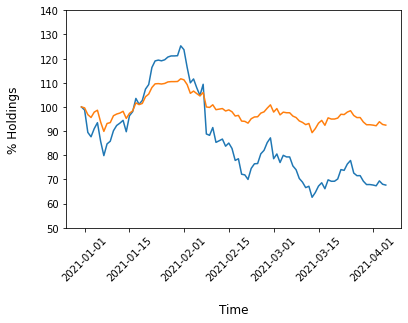

In [37]:
returns_without_adj2 = backtest_regression_noSentiment([x[0] for x in yhat2], 
                                                      data.date.tolist(), 
                                                      "LSTM_regression_no_sentiment")
returns_with_adj2 = backtest_regression_WithSentiment([x[0] for x in yhat2], 
                                  data.date.tolist(), 
                                  sentiments, "LSTM_regression_with_sentiment")

plt.plot([data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist(), [100*x for x in returns_without_adj2])
plt.plot([data.date.tolist()[0]- timedelta(days=1),] + data.date.tolist(), [100*x for x in returns_with_adj2])
plt.xticks(rotation = 45)
plt.ylim(bottom = 50, top = 140)
plt.ylabel("% Holdings", labelpad = 20, fontsize = 12)
plt.xlabel("Time", labelpad = 20, fontsize = 12)
plt.show()